# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

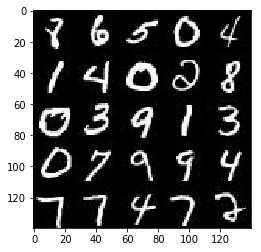

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

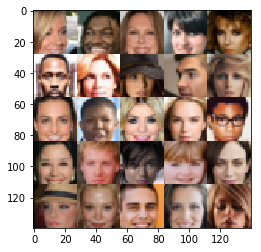

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/arthur_caillau/anaconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32)
    
    return real_input, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2

    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 13, strides=1, padding='valid')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    samples, losses = [], []
    steps = 0
    
    # Building the NN
    real_input, z_input, lr = model_inputs(
        data_shape[1], 
        data_shape[2], 
        data_shape[3], 
        z_dim
    )
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, z_input, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2864... Generator Loss: 1.7706
Epoch 1/2... Discriminator Loss: 0.5082... Generator Loss: 8.5859
Epoch 1/2... Discriminator Loss: 0.1727... Generator Loss: 11.0261
Epoch 1/2... Discriminator Loss: 0.0268... Generator Loss: 4.4640
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 5.3218
Epoch 1/2... Discriminator Loss: 0.1292... Generator Loss: 2.6808
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 15.7134
Epoch 1/2... Discriminator Loss: 0.1037... Generator Loss: 11.5333
Epoch 1/2... Discriminator Loss: 0.2354... Generator Loss: 2.1537
Epoch 1/2... Discriminator Loss: 0.4412... Generator Loss: 1.5934


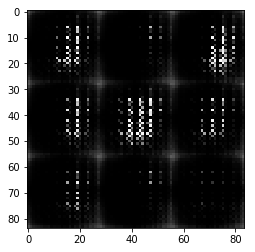

Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 2.1599
Epoch 1/2... Discriminator Loss: 0.1937... Generator Loss: 2.5905
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.7372
Epoch 1/2... Discriminator Loss: 0.1371... Generator Loss: 2.8316
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 3.2313
Epoch 1/2... Discriminator Loss: 0.0698... Generator Loss: 3.4084
Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 3.4805
Epoch 1/2... Discriminator Loss: 0.0931... Generator Loss: 3.5461
Epoch 1/2... Discriminator Loss: 0.1099... Generator Loss: 2.6854
Epoch 1/2... Discriminator Loss: 0.1503... Generator Loss: 2.8996


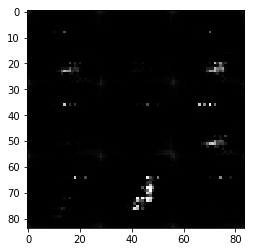

Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 0.0907... Generator Loss: 3.6752
Epoch 1/2... Discriminator Loss: 0.0589... Generator Loss: 4.0458
Epoch 1/2... Discriminator Loss: 0.3726... Generator Loss: 8.6284
Epoch 1/2... Discriminator Loss: 0.1815... Generator Loss: 2.9630
Epoch 1/2... Discriminator Loss: 0.1654... Generator Loss: 4.6701
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 15.1459
Epoch 1/2... Discriminator Loss: 0.0447... Generator Loss: 3.9105
Epoch 1/2... Discriminator Loss: 0.0940... Generator Loss: 3.2793
Epoch 1/2... Discriminator Loss: 0.0488... Generator Loss: 3.9056


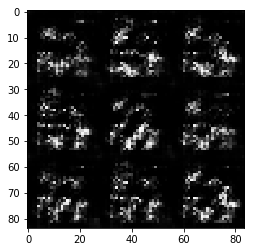

Epoch 1/2... Discriminator Loss: 0.0551... Generator Loss: 5.2506
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 8.1017
Epoch 1/2... Discriminator Loss: 0.0145... Generator Loss: 5.8713
Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 6.9835
Epoch 1/2... Discriminator Loss: 0.0097... Generator Loss: 5.6485
Epoch 1/2... Discriminator Loss: 0.0086... Generator Loss: 5.7055
Epoch 1/2... Discriminator Loss: 0.0164... Generator Loss: 4.4677
Epoch 1/2... Discriminator Loss: 0.0426... Generator Loss: 3.5342
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 14.5423
Epoch 1/2... Discriminator Loss: 0.0287... Generator Loss: 5.1400


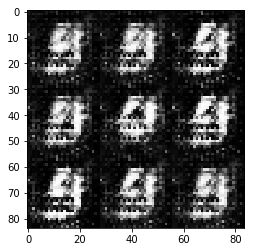

Epoch 1/2... Discriminator Loss: 0.0066... Generator Loss: 5.5799
Epoch 1/2... Discriminator Loss: 1.8032... Generator Loss: 0.2158
Epoch 1/2... Discriminator Loss: 0.1135... Generator Loss: 3.7595
Epoch 1/2... Discriminator Loss: 0.1326... Generator Loss: 4.2275
Epoch 1/2... Discriminator Loss: 0.2407... Generator Loss: 2.7528
Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 3.3868
Epoch 2/2... Discriminator Loss: 0.2552... Generator Loss: 4.1296
Epoch 2/2... Discriminator Loss: 0.5577... Generator Loss: 4.2923
Epoch 2/2... Discriminator Loss: 0.4898... Generator Loss: 4.1658
Epoch 2/2... Discriminator Loss: 0.2272... Generator Loss: 2.4594


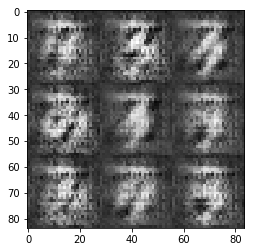

Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 2.8336
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 0.1723... Generator Loss: 2.9822
Epoch 2/2... Discriminator Loss: 0.2328... Generator Loss: 3.0599
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 1.5977
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 5.1697
Epoch 2/2... Discriminator Loss: 0.2641... Generator Loss: 3.1411
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 4.2063
Epoch 2/2... Discriminator Loss: 0.2222... Generator Loss: 3.1818
Epoch 2/2... Discriminator Loss: 0.0748... Generator Loss: 3.8804


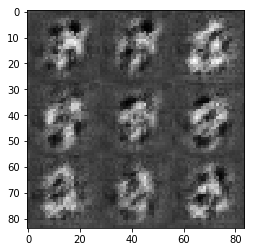

Epoch 2/2... Discriminator Loss: 0.1108... Generator Loss: 3.9000
Epoch 2/2... Discriminator Loss: 0.0502... Generator Loss: 4.2995
Epoch 2/2... Discriminator Loss: 0.2205... Generator Loss: 3.7342
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 0.0919... Generator Loss: 4.3727
Epoch 2/2... Discriminator Loss: 0.1277... Generator Loss: 3.2108
Epoch 2/2... Discriminator Loss: 0.1132... Generator Loss: 2.9653
Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 7.2280
Epoch 2/2... Discriminator Loss: 0.0180... Generator Loss: 5.9252
Epoch 2/2... Discriminator Loss: 0.0394... Generator Loss: 6.0720


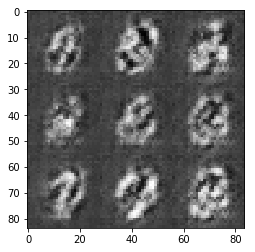

Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.7873
Epoch 2/2... Discriminator Loss: 0.0432... Generator Loss: 4.4394
Epoch 2/2... Discriminator Loss: 0.2651... Generator Loss: 1.8101
Epoch 2/2... Discriminator Loss: 0.0166... Generator Loss: 6.2435
Epoch 2/2... Discriminator Loss: 0.0270... Generator Loss: 6.0640
Epoch 2/2... Discriminator Loss: 0.1434... Generator Loss: 2.6883
Epoch 2/2... Discriminator Loss: 0.0239... Generator Loss: 7.2335
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 6.1769
Epoch 2/2... Discriminator Loss: 0.2276... Generator Loss: 10.6604
Epoch 2/2... Discriminator Loss: 0.0348... Generator Loss: 4.5859


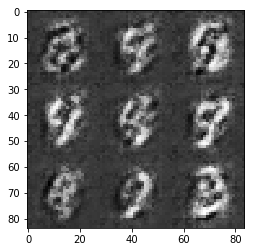

Epoch 2/2... Discriminator Loss: 0.0197... Generator Loss: 6.4137
Epoch 2/2... Discriminator Loss: 0.0225... Generator Loss: 7.2700
Epoch 2/2... Discriminator Loss: 0.0452... Generator Loss: 7.3601
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 8.0737
Epoch 2/2... Discriminator Loss: 0.0213... Generator Loss: 9.1899
Epoch 2/2... Discriminator Loss: 0.0500... Generator Loss: 4.6813
Epoch 2/2... Discriminator Loss: 0.0688... Generator Loss: 3.7455
Epoch 2/2... Discriminator Loss: 0.0260... Generator Loss: 5.0579
Epoch 2/2... Discriminator Loss: 0.0744... Generator Loss: 3.5062
Epoch 2/2... Discriminator Loss: 0.0610... Generator Loss: 4.2512


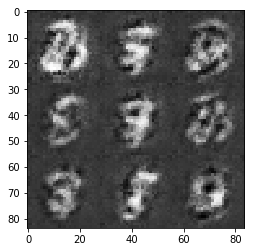

Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 5.5479
Epoch 2/2... Discriminator Loss: 0.0692... Generator Loss: 3.5139
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 3.7981


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode
    )

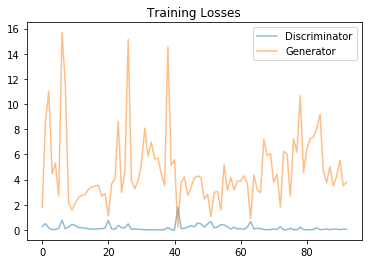

In [13]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 6.3260
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.9712
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 2.1946
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 4.1597
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 9.4714
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 2.6677
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 12.1712
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 7.8872
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 8.4585
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.4711


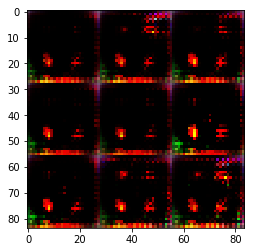

Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 7.4010
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 3.4352
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 8.0778
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 5.3895
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 7.0546
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.2832
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.5521
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.7775
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 4.4780


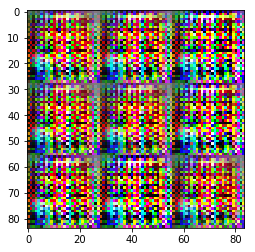

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 9.3965
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.3552
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 6.0804
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 5.2064
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 11.2377
Epoch 1/1... Discriminator Loss: 0.0281... Generator Loss: 3.7984
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.6569
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 11.6339
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 12.6819
Epoch 1/1... Discriminator Loss: 0.2409... Generator Loss: 2.1235


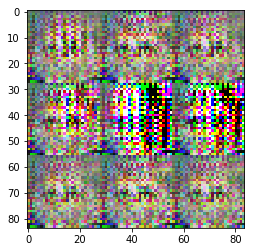

Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.1136
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 14.6622
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 13.2979
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8938
Epoch 1/1... Discriminator Loss: 0.1500... Generator Loss: 2.3275
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8932
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.5500
Epoch 1/1... Discriminator Loss: 2.1820... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 4.6036


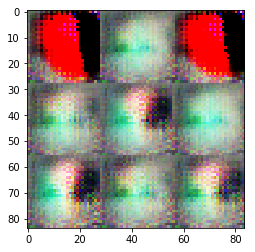

Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.3541
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 2.8447
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.7804
Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 2.5288
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 4.0377
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 2.5509
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 3.0113


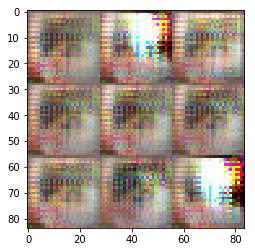

Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 4.6213
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 4.4082
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 6.1796
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 3.8621
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 3.4736
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 4.1829
Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 3.6652
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 7.2167
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 6.1453
Epoch 1/1... Discriminator Loss: 0.0307... Generator Loss: 4.0315


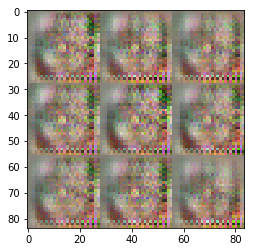

Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 4.3973
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 5.1569
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 7.2296
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 6.6280
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.3383
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 6.3686
Epoch 1/1... Discriminator Loss: 5.4713... Generator Loss: 0.0088
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 5.9449
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 14.7507


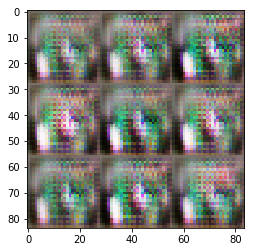

Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 4.7370
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 3.8551
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 4.8550
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 17.4198
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.7895
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 5.1181
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 7.6754
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 4.5120
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 5.5686
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 6.4633


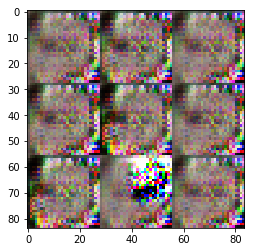

Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 4.9263
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 5.2392
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.2971
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 6.1713
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 8.0546
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.3498
Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 4.5070
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 4.0605
Epoch 1/1... Discriminator Loss: 8.3146... Generator Loss: 0.0021
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 4.0036


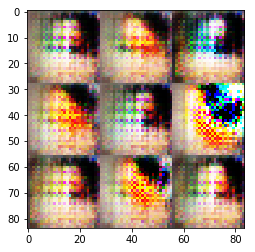

Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 1.8907
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 5.5285
Epoch 1/1... Discriminator Loss: 0.2123... Generator Loss: 2.9633
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 5.5610
Epoch 1/1... Discriminator Loss: 8.9553... Generator Loss: 12.9100
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 3.9791
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 11.8596


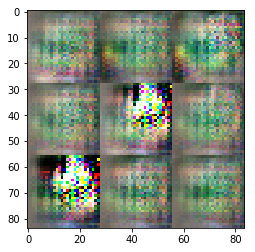

Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 2.8134
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 4.8031
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.4437
Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 7.6392
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 4.2786
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 3.1081
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 9.2949
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 5.5808
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.9956
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.3786


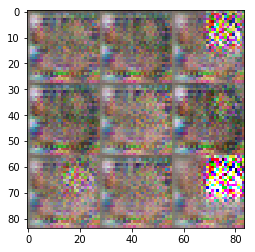

Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 4.0289
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 4.2877
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 4.1808
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 8.1529
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.8517
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.0537
Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 2.6618
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 7.3464
Epoch 1/1... Discriminator Loss: 2.5014... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 3.6363


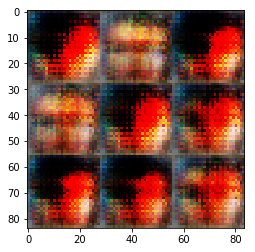

Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 4.3161
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.9624
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 2.5552
Epoch 1/1... Discriminator Loss: 5.0525... Generator Loss: 0.0329
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 2.2970... Generator Loss: 6.1800


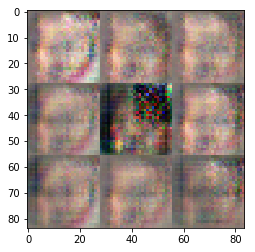

Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 2.5827
Epoch 1/1... Discriminator Loss: 0.1745... Generator Loss: 2.3094
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.5074
Epoch 1/1... Discriminator Loss: 0.2013... Generator Loss: 3.3376
Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 2.9349
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 3.4842
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 3.2062
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.8168


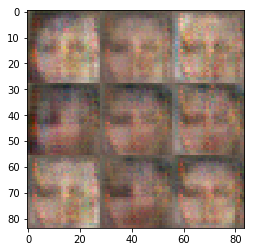

Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 3.1317
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 3.3775... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 2.1592
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.4656


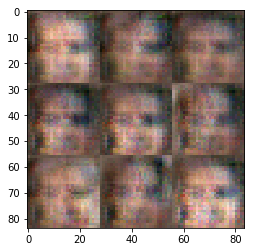

Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.9001
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 3.2868
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.9585
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.9475... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.3142


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        celeba_dataset.get_batches,
        celeba_dataset.shape, 
        celeba_dataset.image_mode
    )

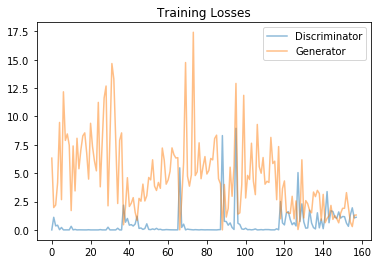

In [15]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.